In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import os
import allel
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, precision_score, accuracy_score, cohen_kappa_score, f1_score
from sklearn.decomposition import PCA, KernelPCA
from sklearn.pipeline import Pipeline


import umap.umap_ as umap

In [3]:
home = os.path.expanduser('~')
directory = os.path.join('Imp_Research','Dataset')

populations = ['BFcol','BFgam','AOcol','CIcol','CMgam','FRgam',
              'GAgam','GHcol','GHgam','GM','GNcol','GNgam','GQgam',
              'GW','KE','UGgam']
R_SEED = 22

In [4]:
# Creating a dictionary of Population names with labels
populations_labels = {}
for i in range(len(populations)):
    populations_labels[i] = populations[i]

### Functions to Load and Pre-Process the Datasets

In [5]:
'''
Requirements : NumPy and Scikit-Allel
'''

class FilterSNP():
    def __init__(self,haplotype, POS):
        self.haplotype = haplotype
        self.POS = POS
        self.H = haplotype
        self.P = POS
        self._removed_maf = None
        self._retained_maf = None
        self._retained_ld = None
        self._removed_ld = None
        self._unlinked_POS = None
        
    def all_filters(self, LD_window_size, LD_overlap_step, MBP_start = 1, MBP_end = 37, MAF_threshold = 5, LD_threshold=.1,LD_iter=1):
        print("1.) Selecting Mega Base Pairs")
        self.H,self.P = self.get_haplo_MBP(self.H,self.P,start = MBP_start, end = MBP_end)
        print("MBP selected. Retained Matrix = ", self.H.shape)
        print("2.) Filtering Rare Allels")
        self.H,self.P = self.filter_MAF(self.H,self.P,threshold = MAF_threshold)
        print("3.) Performing LD Pruning")
        self.H,self.P = self.LD_pruning(self.H, self.P, LD_window_size, LD_overlap_step, threshold = LD_threshold, n_iter = LD_iter)
        print("Retained Haplotype Matrix = ", self.H.shape)
        print("Retained Positions Matrix = ",self.P.shape)
        
        return self.H, self.P
        
    # input dimensions for Haplotype matrix (gn) = SNP X n
    def filter_MAF(self,haplo,POS,threshold = 5):
        if threshold >= 50 : 
            print("MAF threshold cannot be more than 49%")
            return
        samples = haplo.shape[1]
        sums = haplo.sum(axis=1)
        maf = self.get_MAF(haplo)
        #indexes = np.where(maf >= threshold*0.01)[0]
        minor = samples*threshold/100
        major = samples*(100-threshold)/100
        # Selects indexes where allels are >threshold or all 0 and all 1.
        indexes = np.where((sums>=minor)& (sums<=major))[0]
        print("Number of SNPs removed = ",len(haplo)-len(indexes))
        print("Retaining = ",len(indexes))
        self._removed_maf = len(haplo)-len(indexes)
        self._retained_maf = len(indexes)
        return np.take(haplo,indexes,0), np.take(POS,indexes,0)

    # Returns : Array of MAF
    # input dimensions for Haplotype matrix (gn) = SNP X n
    def get_MAF(self,haplo):
        samples = haplo.shape[1]
        sums = haplo.sum(axis=1)
        maf = []
        for s in sums:
            if s != samples or s != 0:
                frequency = s/samples
                if frequency > 0.5:
                    maf.append(1-frequency)
                else: 
                    maf.append(frequency)
        return np.array(maf)

    # input dimensions for Haplotype matrix (gn) = SNP X n
    def get_MBP(self,POS,start = 1,end = 37):
        return np.where(POS[np.where(POS>=1e6)]<=37e6)[0]

    # input dimensions for Haplotype matrix (gn) = SNP X n
    def get_haplo_MBP(self,haplotype,POS,start = 1,end = 37):
        index = self.get_MBP(POS,start,end)
        return np.take(haplotype,index,0),np.take(POS,index,0)
    
    # input dimensions for Haplotype matrix (gn) = SNP X n
    def LD_pruning(self, gn, pos, size, step, threshold = .1, n_iter=1):
        removed = 0
        for i in range(n_iter):
            
            # Returns a boolean array. True(1) - SNPs are within threshold (Unliked), False(0) = Linked
            loc_unlinked = allel.locate_unlinked(gn, size=size, step=step, threshold=threshold)
            
            # Counts non-zero elements = No. of unlinked loci or SNPs to retain
            n = np.count_nonzero(loc_unlinked)
            
            # Calculate the number of SNPs to be removed
            n_remove = gn.shape[0] - n
            removed += n_remove
            print('iteration', i+1, 'retaining', n, 'removing', n_remove, 'variants')
            
            # Select only the unlinked SNPs, i.e., indexes where value is True(1).
            gn = gn.compress(loc_unlinked, axis=0)
            
            # retaining the indexes preserved
            pos = pos.compress(loc_unlinked)
        self._retained_ld = gn.shape[0]
        self._removed_ld = removed
        self._unlinked_POS = pos
        return gn,pos

In [154]:
'''
Disclaimer : The class is for personal use. It is not aimed for portability or reusability.

Class to load and filter the data from disk.
Object Parameters : 
data_path  -> Path to the data directory

load_pop() : Function to load the data
params : 
Populations -> list or array of population names/filenames
filtered -> boolean, whethere to filter the data or not
combine -> Boolean, to combine the populations (Implement it !!!)

returns : A dictionary of haplotype matrix and Position array
'''

class LoadFilteredPops():
    def __init__(self,data_path = None):
        self.data_path = data_path
        
    def load_pop(self,populations,naming='custom',chromo_arms = ['3R'],filtered = True):
        if self.data_path is None:
            home = os.path.expanduser('~')
            directory = os.path.join('Imp_Research','Dataset')
        Haplo_pop = {}
        POS_pop = {}
        for population in populations:
            for arm in chromo_arms:
                pop_name = population+'.'+arm
                if naming == 'custom':
                    filename = f'Haplotype.POS.{pop_name}.hd5'
                else:
                    filename = population
                if self.data_path is None:
                    data_path = os.path.join(home, directory,"HDF_Dataset", filename)
                else:
                    try:
                        data_path = os.path.join(self.data_path,filename)
                    except:
                        print("Cannot resolve Directory path")
                        exit()
                print(f'------{pop_name}------\n')
                H = pd.read_hdf(data_path,key='Haplotype').astype('int8').to_numpy().astype('int8')
                P = pd.read_hdf(data_path,key='POS').to_numpy()
                
                if filtered:
                    # Uses FilterSNP class for filtering steps
                    datafilter = FilterSNP(H,P)
                    Haplo_pop[pop_name],POS_pop[pop_name] = datafilter.all_filters(LD_window_size = 500,LD_overlap_step = 100,LD_iter = 3)
                else: 
                    Haplo_pop[pop_name],POS_pop[pop_name] = H,P
                del H,P     
        print("Populations loaded !!!")
        return Haplo_pop,POS_pop

    
'''
Function to combine the populations
Input Params
Haplo_all : Dictionary containing Haplotype matrix for populations. Key-> pop name; Value -> matrix.
            Matrix dimensions must be POS x haplotypes.
POS_all : Position array of SNPs
filtered : Boolean, to filter after combining or not.
get_labels : Boolean, to generate labels

returns
Haplo_all : ndarray of n x m dimensions. n = length of POS array; m = sum of haplotypes from all populations.
POS : SNP Position array
labels : list of labels if Labels = []
'''

# def all_filters(self, LD_window_size, LD_overlap_step, MBP_start = 1, 
#                 MBP_end = 37, MAF_threshold = 5, LD_threshold=.1,LD_iter=1):

def combine_pops(H_all,P_all,filtered = True,get_labels = True,LD_window_size = 500, LD_overlap_step = 100,
                 MBP_start = 1, MBP_end = 37, MAF_threshold = 5, LD_threshold=.1,LD_iter=3):
    keys = list(H_all.keys())
    
    # Unpacking the Haplotype matrices of all pops from dictionary
    H = np.array(H_all[keys[0]])
    if len(H_all) > 1:
        for i in range(1,len(H_all)):
            H = np.append(H,H_all[keys[i]],axis=1)
    print('Combined Shape => ',H.shape)
    # Generating Labels if True
    if get_labels:
        label = []
        for each in keys:
            label.extend([each]*len(H_all[each][0]))
                          
    # Returning the combined Haplotype data matrix if Filtered = False
    if filtered == False:
        if get_labels:
            return H,P_all,label
        else:
            return H,p_all
    else:
        # Uses FilterSNP class for filtering steps
        datafilter = FilterSNP(H,P_all)
        H_filtered,POS_filtered = datafilter.all_filters(LD_window_size,LD_overlap_step,MBP_start,MBP_end,
                                                            MAF_threshold,LD_threshold,LD_iter)
        print('Final Filtered Shape = ',H_filtered.shape)
        if get_labels:
            return H_filtered,POS_filtered,label
        else:
            return H_filtered,POS_filtered
        

### Loading Dataset

In [7]:
# Loading dataset into the memory

# Using the custom loader class
loader = LoadFilteredPops()
Haplo_all, POS_all = loader.load_pop(populations,filtered = False)

------BFcol.3R------

------BFgam.3R------

------AOcol.3R------

------CIcol.3R------

------CMgam.3R------

------FRgam.3R------

------GAgam.3R------

------GHcol.3R------

------GHgam.3R------

------GM.3R------

------GNcol.3R------

------GNgam.3R------

------GQgam.3R------

------GW.3R------

------KE.3R------

------UGgam.3R------

Populations loaded !!!


In [151]:
comb_pop, comb_pos , l = combine_pops(Haplo_all,POS_all['BFcol.3R'],filtered = False)

Combined Shape =>  (4836295, 2284)


In [152]:
np.unique(comb_pop)

array([0, 1], dtype=int8)

In [393]:
# Did some damage control !!! Ignore :\
# keys = list(Haplo_all.keys())
# pop_labels = []
# for each in keys:
#     pop_labels.extend([each]*len(Haplo_all[each][0]))

In [8]:
# Combining and Filtering the SNPs together through "combine_pops" function

H_allF, POS_allF, pop_labels = combine_pops(Haplo_all,POS_all['BFcol.3R'],filtered = True)

# To retain the positions simply pass along a list of index values.
# Remove the same indexes as POS hence we will know which indexes to use while infering from models.

Combined Shape =>  (4836295, 2284)
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 2284)
2.) Filtering Rare Allels
Number of SNPs removed =  3451543
Retaining =  200177
3.) Performing LD Pruning
iteration 1 retaining 117993 removing 82184 variants
iteration 2 retaining 117494 removing 499 variants
iteration 3 retaining 117461 removing 33 variants
Retained Haplotype Matrix =  (117461, 2284)
Retained Positions Matrix =  (117461,)
Final Filtered Shape =  (117461, 2284)


In [9]:
len(POS_allF)

117461

In [10]:
H_allF.shape

(117461, 2284)

In [33]:
# Generating Labels
labels_all = pd.DataFrame(pop_labels)
labels_all[0] = labels_all[0].str[:-3]
print(labels_all[0].to_numpy())
# Name coded class labels
labels_allname = labels_all[0].to_numpy(dtype=str)

# Number coded class labels
for i in range(len(populations)):
    labels_all[0].replace(populations[i],i,inplace=True)
labels_all = labels_all[0].to_numpy()

['BFcol' 'BFcol' 'BFcol' ... 'UGgam' 'UGgam' 'UGgam']


In [17]:
print(H_allF.shape,POS_allF.shape,len(labels_allname))

(117461, 2284) (117461,) 2284


In [452]:
H = pd.DataFrame(H_allF).astype('int8')
H.to_hdf('Datasets/H_16Filtered.hd5',key='Haplotype',format='fixed',mode='w',complevel=9)
P = pd.DataFrame(POS_allF)
P.to_hdf('Datasets/POS_16Filtered.hd5',key='POS',format='fixed',mode='a',complevel=9)
L = pd.DataFrame(labels_allname)
L.to_csv('Datasets/Labels_name16Filtered.csv',index=False)

del H,P,L

#### Removing GQgam, GHgam and GNcol due to small sample size

In [36]:
H_13 = H_allF.copy()

# Needs to be done because np.where works on shape (n,1) and not (n,)
labels_a = pd.DataFrame(pop_labels)
labels_a[0] = labels_a[0].str[:-3]
labels_a = labels_a.to_numpy()

# finding the indexes of the samples of given pops.
remove_pop = np.where((labels_a == ['GQgam','GHgam','GNcol']))
print("Smaples to be removed",remove_pop[0].shape)

# removing the samples
H_13 = np.delete(H_13,remove_pop[0],1)
print("Samples retained ",H_13.shape)

# Generating new labels for remaining 13 pops
labels_13name = np.delete(labels_allname,remove_pop[0])
labels_13 = np.delete(labels_all,remove_pop[0])

# Generating Genotype labels
removeL = range(0,len(labels_13name),2)
labels_g13name = np.delete(labels_13name,removeL)

Smaples to be removed (50,)
Samples retained  (117461, 2234)


### Generating Train and Test sets
#### From now on we will use N x SNP dimensions for the data

In [37]:
# Haplotype Dataset

# X -> complete dataset (haplotypes x SNPs)
# Y -> corresponding class(population) labels

# Taking Transpose to covert SNP x N -> N x SNP
X = H_13.T.copy()
Y = labels_13.copy()

# Patterson Scaled
X_s = allel.PattersonScaler().fit_transform(X)


In [38]:
X.shape

(2234, 117461)

In [39]:
# Generating Genotype (Unphased) Dataset by combining 2 rows of Filtered Haplotype data(Phased)
'''
The genotype data has 3 values : 0,1,2
0 -> 00
1 -> 01 or 10
2 -> 11

1117 Samples across 13 populations.
'''

X_g = []
for i in range(0,len(X),2):
    X_g.append(X[i]+X[i+1])
X_g = np.array(X_g)

print("The shape of Genotype data ",X_g.shape)

# Generating Genotype labels

removeL = range(0,len(Y),2)
Y_g = np.delete(Y,removeL)
print("The shape of Genotype data labels ",Y_g.shape)

The shape of Genotype data  (1117, 117461)
The shape of Genotype data labels  (1117,)


In [40]:
# Patterson scaled genotype data
X_gs = allel.PattersonScaler().fit_transform(X_g)

In [41]:
# Stratified Train-Test Split

'''
Stratified Splitting : Representation of all the populations is there in test set.

Data split : Train = 80%, Test = 20%
x_train and y_train -> training data and training labels
x_test and y_test -> testing data and test labels
labels : Array of number coded labels
'''

# For Haplotye dataset
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size = 0.2,stratify = Y, random_state = R_SEED)

# For Genotype dataset
x_gtrain, x_gtest, y_gtrain, y_gtest = train_test_split(X_g,Y_g,test_size = 0.2,stratify = Y_g, random_state = R_SEED)

# For Patterson Scaled Genotype dataset
x_gstrain, x_gstest, y_gstrain, y_gstest = train_test_split(X_gs,Y_g,test_size = 0.2,stratify = Y_g, random_state = R_SEED)

# # For UMAP components dataset
# x_utrain, x_utest, y_utrain, y_utest = train_test_split(X_U,Y_g,test_size = 0.2,stratify = Y_g, random_state = R_SEED)

print("Haplotype Train set: \t",x_train.shape)
print("Haplotype Test set: \t",x_test.shape)
print("Genotype Train set: \t",x_gtrain.shape)
print("Genotype Test set: \t",x_gtest.shape)

Haplotype Train set: 	 (1787, 117461)
Haplotype Test set: 	 (447, 117461)
Genotype Train set: 	 (893, 117461)
Genotype Test set: 	 (224, 117461)


In [43]:
# For UMAP components dataset

UMAP_GModel = umap.UMAP(n_components = 10, n_neighbors=15,metric='euclidean',min_dist=1,spread=5).fit(x_gtrain)
x_ugtrain = UMAP_GModel.embedding_
x_ugtest = UMAP_GModel.transform(x_gtest)

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


In [42]:
# A generic function to evaluate the classification on accuracy, F1 and kappa scores.

def evaluate_classifier(y_true,y_pred,title):
    test_accuracy = accuracy_score(y_true,y_pred)
    f1w = f1_score(y_true,y_pred,average= 'weighted')
    f1mic = f1_score(y_true,y_pred,average= 'micro')
    f1mac = f1_score(y_true,y_pred,average= 'macro')
    kappa = cohen_kappa_score(y_true,y_pred)

    print(title)
    print("Test Accuracy : \t%0.3f"%(test_accuracy*100))
    print("F1-Score Weighted : \t%0.3f"%(f1w))
    print("F1-Score Macro : \t%0.3f"%(f1mac))
    print("F1-Score Micro : \t%0.3f"%(f1mic))
    print("Kappa Score : \t\t%0.3f"%(kappa))

### Linear Discriminant Analysis

In [51]:
# LDA model on Haplo data
lda = LinearDiscriminantAnalysis(solver='svd',n_components = 10)
lda.fit(x_train,y_train)

# lda_s = LinearDiscriminantAnalysis(solver='svd',n_components = 10)
# lda_s.fit(x_train,y_train)

# LDA model on Geno data
lda_g = LinearDiscriminantAnalysis()
lda_g.fit(x_gtrain,y_gtrain)

# LDA model on UMAP embeddings (components)
lda_u = LinearDiscriminantAnalysis()
lda_u.fit(x_ugtrain,y_gtrain)

LinearDiscriminantAnalysis()

In [139]:
# we will calculate weighted ROC-AUC in One vs Rest setting
y_pred = lda.predict(x_test)
print("LDA Classification Train Accuracy : ",lda.score(x_train,y_train))
print("LDA Classification Test Accuracy : ",lda.score(x_test,y_test))
print("LDA Classification Test ROC-AUC : ",roc_auc_score(y_test,lda.predict_proba(x_test),multi_class="ovr", average="weighted"))

LDA Classification Train Accuracy :  0.6536094012311136
LDA Classification Test Accuracy :  0.7740492170022372
LDA Classification Test ROC-AUC :  0.9707653642850848


In [52]:
# we will calculate weighted ROC-AUC in One vs Rest setting
y_pred = lda_g.predict(x_gtest)
print("LDA Genotype Classification Train Accuracy : ",lda_g.score(x_gtrain,y_gtrain))
evaluate_classifier(y_gtest,y_pred,"LDA\n")

LDA Genotype Classification Train Accuracy :  0.620380739081747
LDA

Test Accuracy : 	70.089
F1-Score Weighted : 	0.651
F1-Score Macro : 	0.627
F1-Score Micro : 	0.701
Kappa Score : 		0.646


In [78]:
# Patterson Scaled Data
y_pred = lda_s.predict(x_test)
print("LDA Classification Train Accuracy : ",lda_s.score(x_train,y_train))
print("LDA Classification Test Accuracy : ",lda_s.score(x_test,y_test))
print("LDA Classification Test ROC-AUC : ",roc_auc_score(y_test,lda_s.predict_proba(x_test),multi_class="ovr", average="weighted"))

LDA Classification Train Accuracy :  0.640695067264574
LDA Classification Test Accuracy :  0.7718120805369127
LDA Classification Test ROC-AUC :  0.9725032493323238


In [476]:
y_pred = lda_u.predict(x_ugtest)
print("LDA Genotype Classification Train Accuracy : ",lda_u.score(x_ugtrain,y_gtrain))
print("LDA Genotype Classification Test Accuracy : ",lda_u.score(x_ugtest,y_gtest))

LDA Genotype Classification Train Accuracy :  0.9518477043673013
LDA Genotype Classification Test Accuracy :  0.6428571428571429


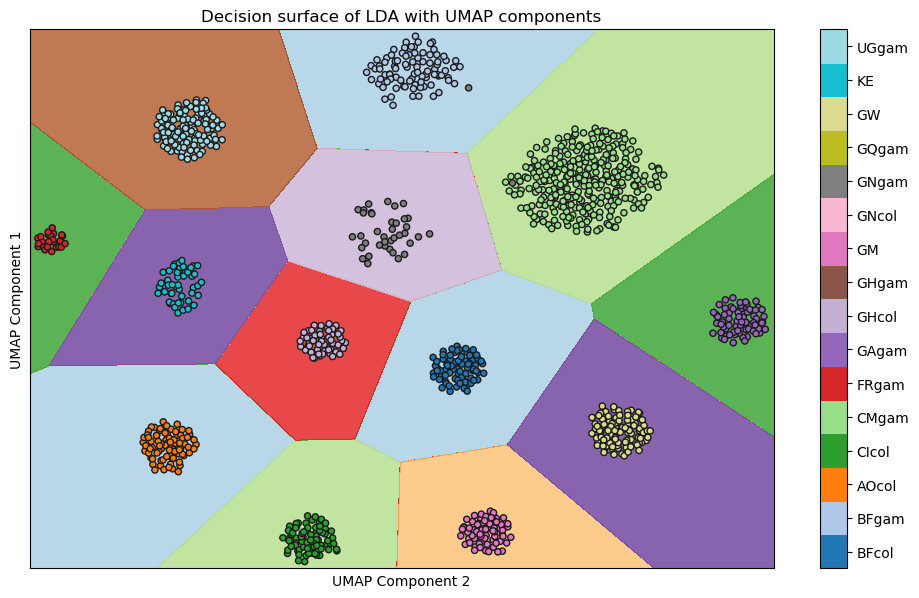

In [282]:
def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

model = LinearDiscriminantAnalysis()
clf = model.fit(X_U, Y_g)

fig, ax = plt.subplots(figsize=(12,7))
# title for the plots
title = ('Decision surface of LDA with UMAP components')
# Set-up grid for plotting.
X0, X1 = X_U[:, 0], X_U[:, 1]
xx, yy = make_meshgrid(X0, X1)

plot_contours(ax, clf, xx, yy, cmap='Paired', alpha=0.8)
plt.scatter(X0, X1, c=Y_g, cmap=plt.cm.tab20, s=20, edgecolors='k')
plt.ylabel('UMAP Component 1')
plt.xlabel('UMAP Component 2')
plt.title(title)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(17)-0.5)
cbar.set_ticks(np.arange(16))
cbar.set_ticklabels(populations)

### Logistic Regression

In [159]:
lr = LogisticRegression(max_iter = 100,n_jobs = -1,verbose=5)
lr.fit(x_gtrain,y_gtrain)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 56 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  7.7min finished


LogisticRegression(n_jobs=-1, verbose=5)

In [221]:
lr_h = LogisticRegression(max_iter = 100,n_jobs = -1,verbose=5)
lr_h.fit(x_train,y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 56 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  9.2min finished


LogisticRegression(n_jobs=-1, verbose=5)

In [224]:
y_predh = lr_h.predict(x_test)
print("LR Haplotype Classification Train Accuracy : ",lr_h.score(x_train,y_train))
print("LR Haplotype Classification Test Accuracy : ",lr_h.score(x_test,y_test))
print("LR Haplotype Classification Test ROC-AUC : ",roc_auc_score(y_test,lr_h.predict_proba(x_test),multi_class="ovr", average="weighted"))

LR Haplotype Classification Train Accuracy :  1.0
LR Haplotype Classification Test Accuracy :  0.8993288590604027
LR Haplotype Classification Test ROC-AUC :  0.996089685865326


In [495]:
y_pred = lr.predict(x_gtest)
print("LR Genotype Classification Train Accuracy : ",lr.score(x_gtrain,y_gtrain))
evaluate_classifier(y_gtest,y_pred,"LR Genotype\n")

LR Genotype Classification Train Accuracy :  1.0
LR Genotype

Test Accuracy : 	90.179
F1-Score Weighted : 	0.872
F1-Score Macro : 	0.862
F1-Score Micro : 	0.902
Kappa Score : 		0.886


#### Feature Exploration Using CatBoost, XGBoost and LGBM

In [255]:
#!pip install catboost
!pip install xgboost
!pip install lightgbm

     |████████████████████████████████| 166.7 MB 10 kB/s s eta 0:00:01  |▏                               | 860 kB 1.9 MB/s eta 0:01:30     |██████████████████▌             | 96.6 MB 77.6 MB/s eta 0:00:01
     |████████████████████████████████| 2.0 MB 2.0 MB/s eta 0:00:01


In [258]:
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

catclf = CatBoostClassifier(n_estimators = 100)
catclf.fit(x_gtrain,y_gtrain)

xgb = XGBClassifier(n_estimators = 1000,n_jobs=-1)
xgb.fit(x_gtrain,y_gtrain)

lgb = LGBMClassifier()
lgb.fit(x_gtrain,y_gtrain)

LGBMClassifier()

In [259]:
y_pred = catclf.predict(x_gtest)
evaluate_classifier(y_gtest,y_pred,"Catboost")

y_pred = xgb.predict(x_gtest)
evaluate_classifier(y_gtest,y_pred,"XGBoost")

y_pred = lgb.predict(x_gtest)
evaluate_classifier(y_gtest,y_pred,"LightGBM")

Catboost
Test Accuracy : 	86.161
F1-Score Weighted : 	0.833
F1-Score Macro : 	0.817
F1-Score Micro : 	0.862
Kappa Score : 		0.839
XGBoost
Test Accuracy : 	86.607
F1-Score Weighted : 	0.845
F1-Score Macro : 	0.818
F1-Score Micro : 	0.866
Kappa Score : 		0.845
LightGBM
Test Accuracy : 	86.607
F1-Score Weighted : 	0.824
F1-Score Macro : 	0.811
F1-Score Micro : 	0.866
Kappa Score : 		0.844


Text(0.5, 1.0, 'Sorted Feature Importance for ~117K SNP on XGboost with 86.1% Accuracy')

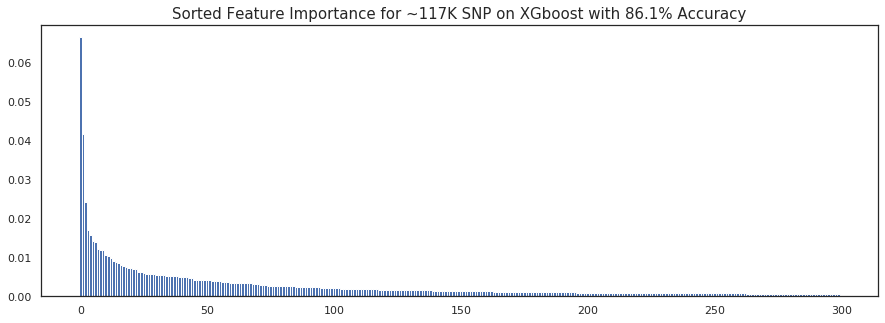

In [279]:
plt.figure(figsize=(15,5))
plt.bar(range(len(xgb.feature_importances_[:300])),sorted(xgb.feature_importances_,reverse=True)[:300],width=1)
plt.title(f"Sorted Feature Importance for ~117K SNP on XGboost with 86.1% Accuracy",fontsize=15)

Text(0.5, 1.0, 'Feature Importance for ~117K SNP on XGBoost with 86.1% Accuracy')

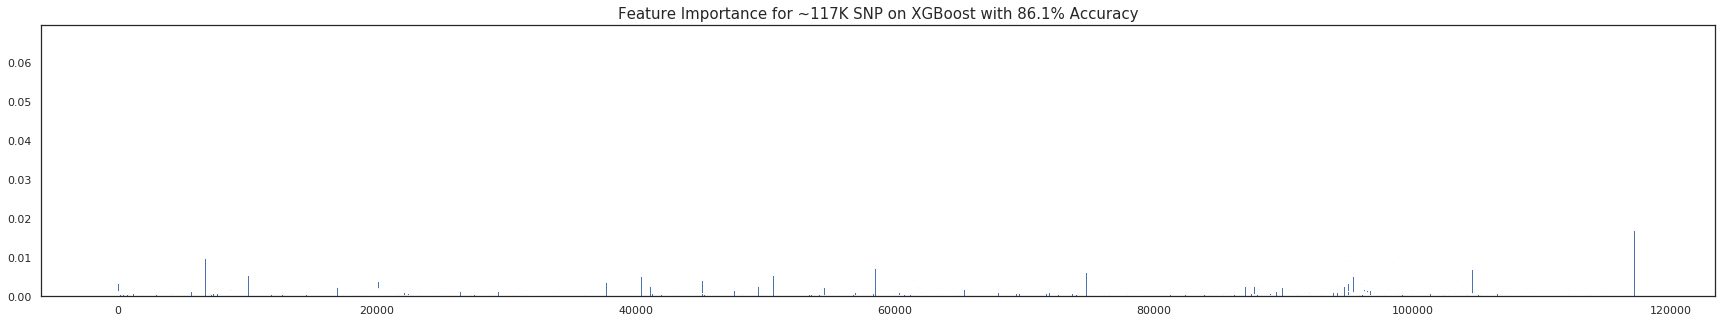

In [261]:
plt.figure(figsize=(30,5))
plt.bar(range(len(xgb.feature_importances_)),xgb.feature_importances_,width=100)
plt.title(f"Feature Importance for ~117K SNP on XGBoost with 86.1% Accuracy",fontsize=15)

Text(0.5, 1.0, 'Feature Importance for ~117K SNP on LightGBM with 86.6% Accuracy')

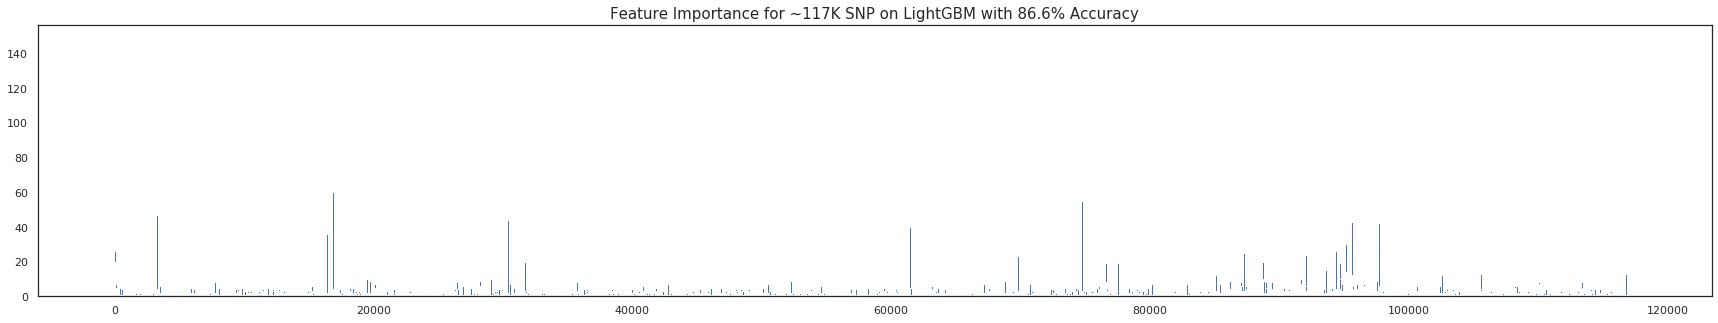

In [262]:
plt.figure(figsize=(30,5))
plt.bar(range(len(lgb.feature_importances_)),lgb.feature_importances_,width=100)
plt.title(f"Feature Importance for ~117K SNP on LightGBM with 86.6% Accuracy",fontsize=15)

#### Exploring a prediction done by LR

In [173]:
for k in range(3):
    probabs = lr.predict_proba(x_gtest)[k]*100
    print(f'Ground Truth: Class {y_gtest[k]} {populations_labels[y_gtest[k]]}')
    print(f'Predicted as: Class {y_pred[k]} {populations_labels[y_pred[k]]}')
    for i in range(len(probabs)):
        print(f'Probability of Class {i} {populations_labels[i]}: \t{probabs[i]}')
    print("-"*50)

Ground Truth: Class 11 GNgam
Predicted as: Class 4 CMgam
Probability of Class 0 BFcol: 	0.05442619734035559
Probability of Class 1 BFgam: 	13.823098992772367
Probability of Class 2 AOcol: 	0.01991886115212178
Probability of Class 3 CIcol: 	0.03543322216116989
Probability of Class 4 CMgam: 	81.75306593338986
Probability of Class 5 FRgam: 	0.015027537943098138
Probability of Class 6 GAgam: 	0.07140868451504785
Probability of Class 7 GHcol: 	0.025140608742485124
Probability of Class 8 GHgam: 	0.07256340081197056
Probability of Class 9 GM: 	2.6129413354481104
Probability of Class 10 GNcol: 	0.0868522256346968
Probability of Class 11 GNgam: 	0.015453965764154287
Probability of Class 12 GQgam: 	1.414669034324549
--------------------------------------------------
Ground Truth: Class 15 UGgam
Predicted as: Class 15 UGgam
Probability of Class 0 BFcol: 	0.020090664839655895
Probability of Class 1 BFgam: 	0.19063705836126446
Probability of Class 2 AOcol: 	0.005720600130391184
Probability of Class

#### Exploring the SNP/feature importance through LR

In [ ]:
# lr : the model is fit in above cells

importance = lr.coef_[0]

# summarize feature importance
# for i,v in enumerate(importance):
#     print('Feature: %0d, Score: %.5f' % (i,v))

# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

#### UMAP components to fit Logistic Regression

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


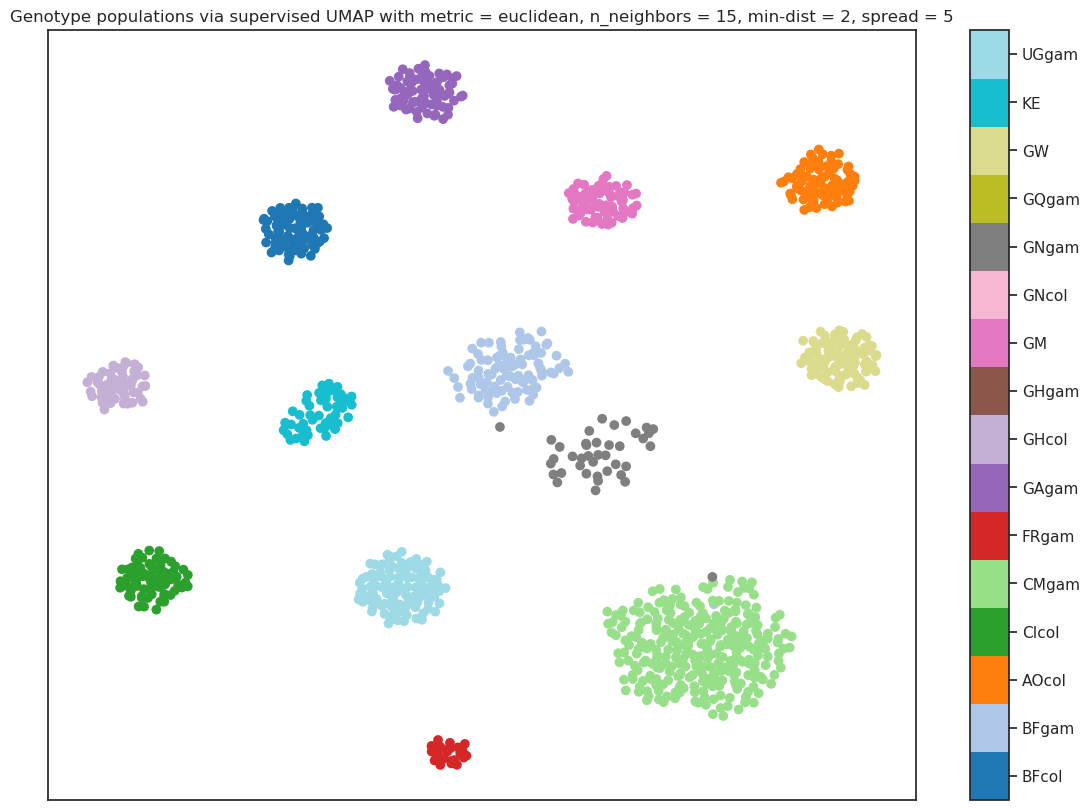

In [286]:
UMAP_g = umap.UMAP(n_neighbors=15,metric='euclidean',min_dist=2,spread=5).fit_transform(X_g,y = Y_g)

sns.set(style='white')
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(
      UMAP_g[:, 0],
      UMAP_g[:, 1],
      c=Y_g,cmap='tab20')
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(17)-0.5)
cbar.set_ticks(np.arange(16))
cbar.set_ticklabels(populations)
plt.title('Genotype populations via supervised UMAP with metric = euclidean, n_neighbors = 15, min-dist = 2, spread = 5');

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


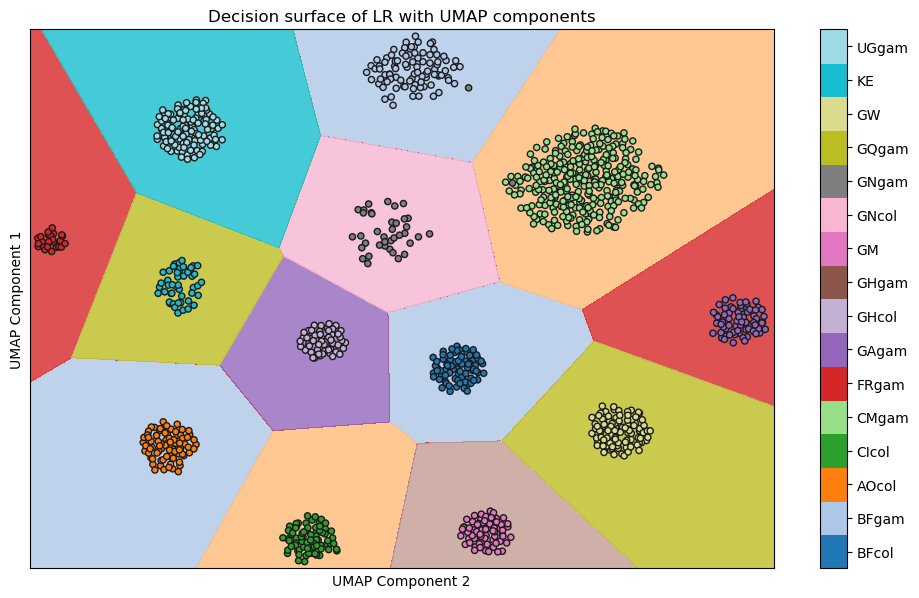

In [281]:
def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

model = LogisticRegression(max_iter = 1000)
clf = model.fit(X_U, Y_g)

fig, ax = plt.subplots(1,figsize=(12,7))
# title for the plots
title = ('Decision surface of LR with UMAP components')
# Set-up grid for plotting.
X0, X1 = X_U[:, 0], X_U[:, 1]
xx, yy = make_meshgrid(X0, X1)

plot_contours(ax, clf, xx, yy, cmap='tab20', alpha=0.8)
plt.scatter(X0, X1, c=Y_g, cmap=plt.cm.tab20, s=20, edgecolors='k')
plt.ylabel('UMAP Component 1')
plt.xlabel('UMAP Component 2')
plt.title(title)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(17)-0.5)
cbar.set_ticks(np.arange(16))
cbar.set_ticklabels(populations)

#### Testing the obtained embeddings from UMAP

In [142]:
# Training a UMAP with Genotypic training data

# Supervised UMAP [Hypothesis : Doesn't perform well because of forced labeling!!!]
#UMAP_GModel = umap.UMAP(n_components = 10,n_neighbors=20,metric='jaccard',min_dist=0.1,spread=1).fit(x_gtrain,y = y_gtrain)

# Unsupervised UMAP
UMAP_GModel = umap.UMAP(n_components = 20, n_neighbors=15,metric='jaccard',min_dist=2,spread=5,random_state = 42).fit(x_gtrain)

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


In [143]:
# Obtaining the tranformed UMAP embeddings (Components)

x_ugtrain = UMAP_GModel.embedding_
x_ugtest = UMAP_GModel.transform(x_gtest)

In [141]:
lr_u = LogisticRegression(max_iter = 100,n_jobs = -1,verbose=5)

lr_u.fit(x_ugtrain,y_gtrain)
y_pred = lr_u.predict(x_ugtest)
print("LR-UMAP Train Accuracy : ",lr_u.score(x_ugtrain,y_gtrain))
evaluate_classifier(y_gtest,y_pred,"LR-UMAP")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 56 concurrent workers.


LR-UMAP Train Accuracy :  0.9585666293393057
LR-UMAP
Test Accuracy : 	94.196
F1-Score Weighted : 	0.930
F1-Score Macro : 	0.911
F1-Score Micro : 	0.942
Kappa Score : 		0.933


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.7s finished


In [144]:
lda_u = LinearDiscriminantAnalysis(solver='svd')
lda_u.fit(x_ugtrain,y_gtrain)
y_pred = lda_u.predict(x_ugtest)
print("LDA-UMAP Train Accuracy : ",lda_u.score(x_ugtrain,y_gtrain))
evaluate_classifier(y_gtest,y_pred,"LDA-UMAP")

LDA-UMAP Train Accuracy :  0.948488241881299
LDA-UMAP
Test Accuracy : 	82.589
F1-Score Weighted : 	0.787
F1-Score Macro : 	0.765
F1-Score Micro : 	0.826
Kappa Score : 		0.802


In [140]:
lr_u = LogisticRegression(max_iter = 100,n_jobs = -1,verbose=5)
lr_u.fit(x_ugtrain,y_gtrain)
print("LR-UMAP Classification Train Accuracy : ",lr_u.score(x_ugtrain,y_gtrain))
print("LR-UMAP Classification Test Accuracy : ",lr_u.score(x_ugtest,y_gtest))

# With sup Jaccard it goes upto 76% Testing accuracy
# With unsup 2 components Jaccard it goes upto 81% Testing accuracy
# With unsup dice it goes upto 81% Testing accuracy
# With unsup dice 10 components LR-UMAP Accuracy :  91%
# With unsup euclidean 10 components LR-UMAP Accuracy :  93.75%

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 56 concurrent workers.


LR-UMAP Classification Train Accuracy :  0.9585666293393057
LR-UMAP Classification Test Accuracy :  0.9419642857142857


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    9.4s finished


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


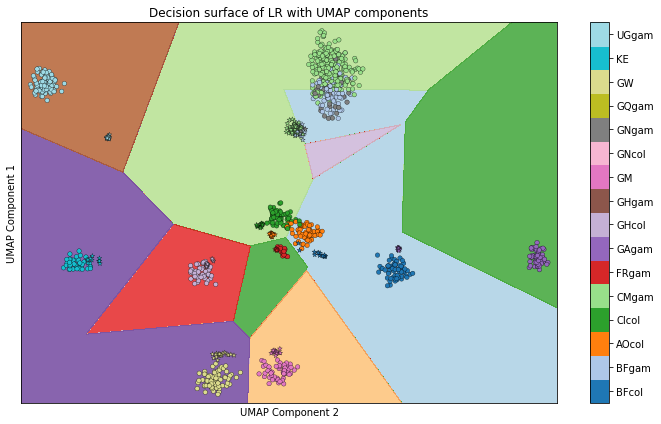

In [136]:
def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

model = LogisticRegression(max_iter = 1000)
# model = LinearDiscriminantAnalysis(solver='svd')
clf = model.fit(x_ugtrain[:,:2], y_gtrain)

fig, ax = plt.subplots(1,figsize=(12,7))
# title for the plots
title = ('Decision surface of LR with UMAP components')
# Set-up grid for plotting.
X0, X1 = x_ugtrain[:, 0], x_ugtrain[:, 1]
xx, yy = make_meshgrid(X0, X1)

plot_contours(ax, clf, xx, yy, cmap='Paired', alpha=0.8)
plt.scatter(X0, X1, c=y_gtrain, cmap=plt.cm.tab20, s=20, edgecolors='k',linewidth= 0.3)
plt.scatter(x_ugtest[:,0],x_ugtest[:,1],c=y_gtest,cmap=plt.cm.tab20, s=25,marker='*',edgecolors='k',linewidth=0.3)
plt.ylabel('UMAP Component 1')
plt.xlabel('UMAP Component 2')
plt.title(title)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(17)-0.5)
cbar.set_ticks(np.arange(16))
cbar.set_ticklabels(populations)

In [ ]:
"""
To Try : 

Data -> UMAP components (3-10) -> Logistic Regression(Any Model)

For inference/predictions the relative components for predictions can be obtained 
from the frozen UMAP model which in turn can be used on LR model.
"""

#### Using PCA for dimensionality reduction

In [46]:
n_components = 50
kernel = 'poly' # linear (default), poly, rbf, cosine and sigmoid

pca_pipe = PCA(n_components = n_components)
kpca_pipe = KernelPCA(n_components = n_components,kernel = kernel, n_jobs=-1)
lr_pipe = LogisticRegression(n_jobs = -1,verbose=5)
lda_pipe = LinearDiscriminantAnalysis()

lr_pca_pipeline = Pipeline([('PCA',pca_pipe),('LR',lr_pipe)])
lr_kpca_pipeline = Pipeline([('KPCA',kpca_pipe),('LR',lr_pipe)])
lda_pca_pipeline = Pipeline([('PCA',pca_pipe),('LDA',lda_pipe)])

In [512]:
# PCA->LR
lr_pca_pipeline.fit(x_gstrain,y_gstrain)

train_accuracy = lr_pca_pipeline.score(x_gstrain,y_gstrain)
y_pred = lr_pca_pipeline.predict(x_gstest)
print("Train Accuracy : \t%0.3f"%(train_accuracy*100))
print("Number of Components :\t",n_components)
evaluate_classifier(y_gstest,y_pred,"\nPCA->Logistic Regression Results\n")

# 10 compoents = 84%

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 56 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s finished


Train Accuracy : 	99.664
Number of Components :	 50

PCA->Logistic Regression Results

Test Accuracy : 	89.732
F1-Score Weighted : 	0.883
F1-Score Macro : 	0.868
F1-Score Micro : 	0.897
Kappa Score : 		0.881


In [49]:
# PCA->LR
lr_kpca_pipeline.fit(x_gtrain,y_gtrain)

train_accuracy = lr_kpca_pipeline.score(x_gstrain,y_gstrain)
y_pred = lr_kpca_pipeline.predict(x_gtest)
print("Train Accuracy : \t%0.3f"%(train_accuracy*100))
print("Number of Components :\t",n_components)
evaluate_classifier(y_gtest,y_pred,"\nKernel PCA->Logistic Regression Results\n")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 56 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.6s finished


Train Accuracy : 	94.625
Number of Components :	 50

Kernel PCA->Logistic Regression Results

Test Accuracy : 	87.946
F1-Score Weighted : 	0.832
F1-Score Macro : 	0.830
F1-Score Micro : 	0.879
Kappa Score : 		0.859


In [48]:
# PCA->LDA
lda_pca_pipeline.fit(x_gstrain,y_gstrain)

train_accuracy = lda_pca_pipeline.score(x_gstrain,y_gstrain)
y_pred = lda_pca_pipeline.predict(x_gstest)
print("Train Accuracy : \t%0.3f"%(train_accuracy*100))
print("Number of Components :\t",n_components)
evaluate_classifier(y_gstest,y_pred,"\nKernel PCA->LDA Results\n")

Train Accuracy : 	95.969
Number of Components :	 50

Kernel PCA->LDA Results

Test Accuracy : 	91.518
F1-Score Weighted : 	0.893
F1-Score Macro : 	0.875
F1-Score Micro : 	0.915
Kappa Score : 		0.902


### Building a training pipeline for UMAP with LDA and LR

In [464]:
# Building a pipeline for better training and evaluation

# UMAP Hyperparameters

metric = 'euclidean'
n_neighbors = 15
min_dist = 2
spread = 5

umap_pipe = umap.UMAP(n_components = 10,n_neighbors=n_neighbors,metric=metric,min_dist=min_dist,spread=spread)
lr_pipe = LogisticRegression(max_iter = 100,n_jobs = -1,verbose=5)
lda_pipe = LinearDiscriminantAnalysis()

LR_pipeline = Pipeline([('umap',umap_pipe),('LR',lr_pipe)])
LDA_pipeline = Pipeline([('umap',umap_pipe),('LDA',lda_pipe)])

In [467]:
#LR_pipeline.fit(x_gtrain,y_gtrain)

train_accuracy = LR_pipeline.score(x_gtrain,y_gtrain)
y_pred = LR_pipeline.predict(x_gtest)
print("Train Accuracy : \t%0.3f"%(train_accuracy*100))
evaluate_pipe(y_gtest,y_pred,"UMAP->Logistic Regression Results\n")

Train Accuracy : 	99.888
UMAP->Logistic Regression Results

Test Accuracy : 	75.000
F1-Score Weighted : 	0.778
F1-Score Macro : 	0.806
F1-Score Micro : 	0.750
Kappa Score : 	0.726


In [ ]:
LDA_pipeline.fit(x_gtrain,y_gtrain)

train_accuracy = LDA_pipeline.score(x_gtrain,y_gtrain)
y_pred = LDA_pipeline.predict(x_gtest)
evaluate_pipe(y_gtest,y_pred,"UMAP->Linea Discriminant Analysis Results\n")
print("Train Accuracy : \t%0.3f"%(train_accuracy*100))

## Analysis of Populations with FST -> 0
### Populations : GNgam, CMgam, BFgam and GHgam

In [183]:
population_lowfst = ['GNgam','CMgam','BFgam','GHgam']
loader = LoadFilteredPops()
Haplo_lowfst, POS_lowfst = loader.load_pop(population_lowfst,filtered = False)
H_lowfst, P_lowfst , labels_lowfst = combine_pops(Haplo_lowfst,POS_lowfst['BFgam.3R'],filtered = True)

------GNgam.3R------

------CMgam.3R------

------BFgam.3R------

------GHgam.3R------

Populations loaded !!!
Combined Shape =>  (4836295, 882)
1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 882)
2.) Filtering Rare Allels
Number of SNPs removed =  3450064
Retaining =  201656
3.) Performing LD Pruning
iteration 1 retaining 117663 removing 83993 variants
iteration 2 retaining 117150 removing 513 variants
iteration 3 retaining 117146 removing 4 variants
Retained Haplotype Matrix =  (117146, 882)
Retained Positions Matrix =  (117146,)
Final Filtered Shape =  (117146, 882)


In [184]:
labels_fst = pd.DataFrame(labels_lowfst)
labels_fst[0] = labels_fst[0].str[:-3]
print(labels_fst[0].to_numpy())
# Name coded class labels
labels_lowfstname = labels_fst[0].to_numpy(dtype=str)

# Number coded class labels
for i in range(len(population_lowfst)):
    labels_fst[0].replace(population_lowfst[i],i,inplace=True)
labels_lowfst = labels_fst[0].to_numpy()

['GNgam' 'GNgam' 'GNgam' 'GNgam' 'GNgam' 'GNgam' 'GNgam' 'GNgam' 'GNgam'
 'GNgam' 'GNgam' 'GNgam' 'GNgam' 'GNgam' 'GNgam' 'GNgam' 'GNgam' 'GNgam'
 'GNgam' 'GNgam' 'GNgam' 'GNgam' 'GNgam' 'GNgam' 'GNgam' 'GNgam' 'GNgam'
 'GNgam' 'GNgam' 'GNgam' 'GNgam' 'GNgam' 'GNgam' 'GNgam' 'GNgam' 'GNgam'
 'GNgam' 'GNgam' 'GNgam' 'GNgam' 'GNgam' 'GNgam' 'GNgam' 'GNgam' 'GNgam'
 'GNgam' 'GNgam' 'GNgam' 'GNgam' 'GNgam' 'GNgam' 'GNgam' 'GNgam' 'GNgam'
 'GNgam' 'GNgam' 'GNgam' 'GNgam' 'GNgam' 'GNgam' 'GNgam' 'GNgam' 'GNgam'
 'GNgam' 'GNgam' 'GNgam' 'GNgam' 'GNgam' 'GNgam' 'GNgam' 'GNgam' 'GNgam'
 'GNgam' 'GNgam' 'GNgam' 'GNgam' 'GNgam' 'GNgam' 'GNgam' 'GNgam' 'CMgam'
 'CMgam' 'CMgam' 'CMgam' 'CMgam' 'CMgam' 'CMgam' 'CMgam' 'CMgam' 'CMgam'
 'CMgam' 'CMgam' 'CMgam' 'CMgam' 'CMgam' 'CMgam' 'CMgam' 'CMgam' 'CMgam'
 'CMgam' 'CMgam' 'CMgam' 'CMgam' 'CMgam' 'CMgam' 'CMgam' 'CMgam' 'CMgam'
 'CMgam' 'CMgam' 'CMgam' 'CMgam' 'CMgam' 'CMgam' 'CMgam' 'CMgam' 'CMgam'
 'CMgam' 'CMgam' 'CMgam' 'CMgam' 'CMgam' 'CMgam' 'C

In [187]:
X_gfst = []
X_lfst = H_lowfst.T.copy()
Y_lfst = labels_lowfst.copy()
for i in range(0,len(X_lfst),2):
    X_gfst.append(X_lfst[i]+X_lfst[i+1])
X_gfst = np.array(X_gfst)

print("The shape of Genotype data ",X_gfst.shape)

# Generating Genotype labels

removeL = range(0,len(Y_lfst),2)
Y_gfst = np.delete(Y_lfst,removeL)
print("The shape of Genotype data labels ",Y_gfst.shape)

The shape of Genotype data  (441, 117146)
The shape of Genotype data labels  (441,)


/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


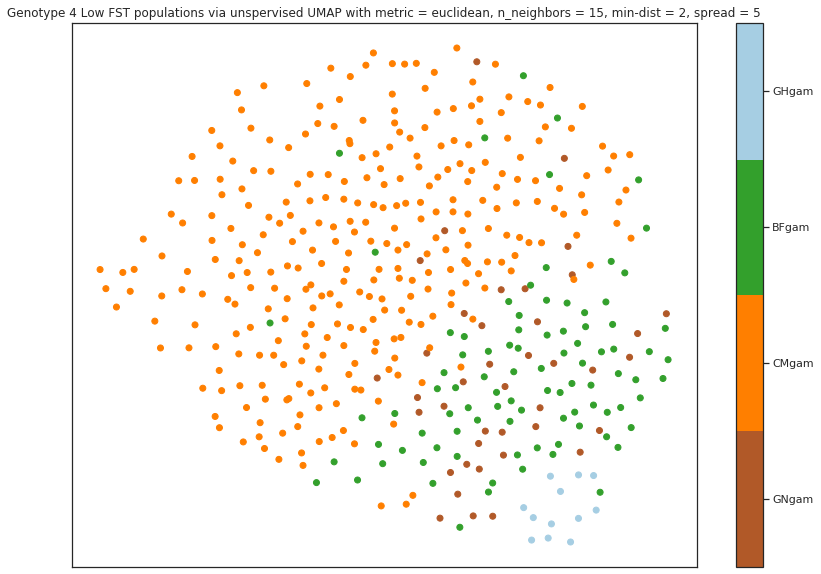

In [220]:
UMAP_g = umap.UMAP(n_neighbors=50,metric='euclidean',min_dist=2,spread=5).fit_transform(X_gfst)

sns.set(style='white')
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(
      UMAP_g[:, 0],
      UMAP_g[:, 1],
      c=Y_gfst,cmap='Paired_r')
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(5)-0.5)
cbar.set_ticks(np.arange(4))
cbar.set_ticklabels(population_lowfst)
plt.title('Genotype 4 Low FST populations via unspervised UMAP with metric = euclidean, n_neighbors = 15, min-dist = 2, spread = 5');

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


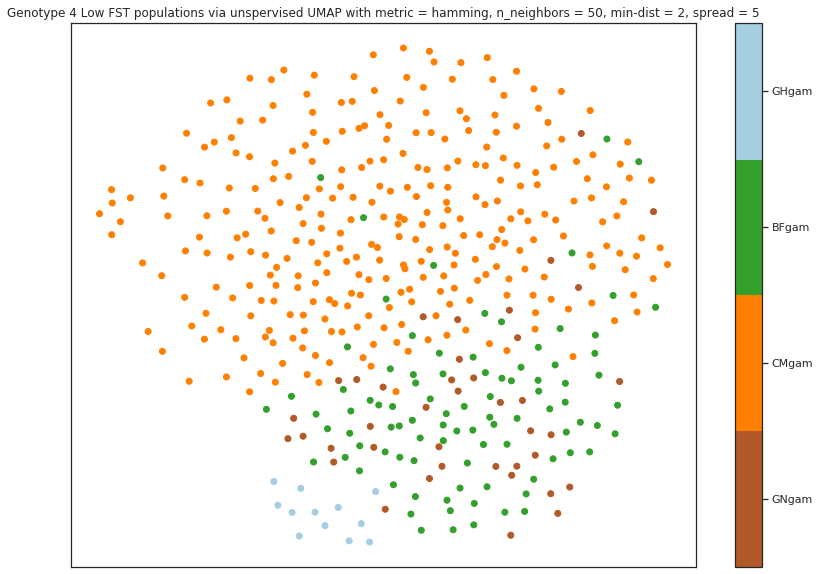

In [221]:
UMAP_g = umap.UMAP(n_neighbors=50,metric='hamming',min_dist=2,spread=5).fit_transform(X_gfst)

sns.set(style='white')
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(
      UMAP_g[:, 0],
      UMAP_g[:, 1],
      c=Y_gfst,cmap='Paired_r')
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(5)-0.5)
cbar.set_ticks(np.arange(4))
cbar.set_ticklabels(population_lowfst)
plt.title('Genotype 4 Low FST populations via unspervised UMAP with metric = hamming, n_neighbors = 50, min-dist = 2, spread = 5');

/home/achal/miniconda3/envs/Imp-Res/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


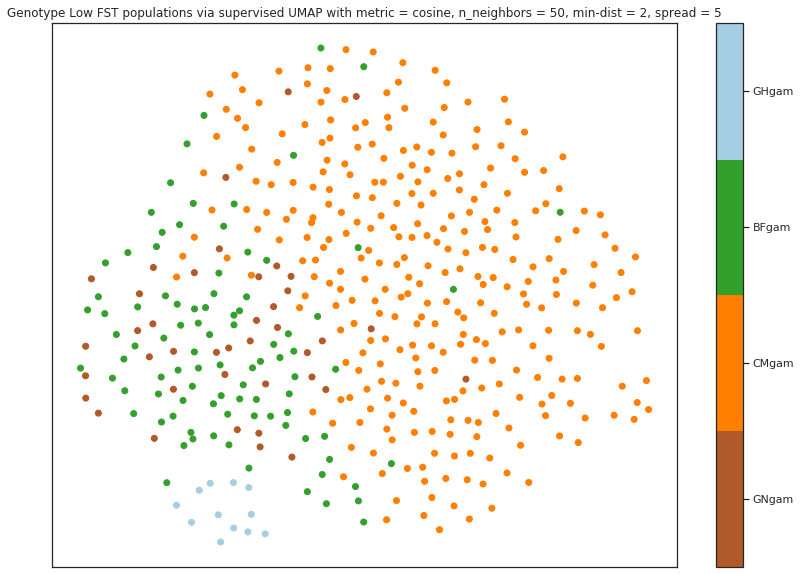

In [232]:
metric = 'cosine'
UMAP_g = umap.UMAP(n_neighbors=50,metric=metric,min_dist=2,spread=5).fit_transform(X_gfst)

sns.set(style='white')
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(
      UMAP_g[:, 0],
      UMAP_g[:, 1],
      c=Y_gfst,cmap='Paired_r')
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(5)-0.5)
cbar.set_ticks(np.arange(4))
cbar.set_ticklabels(population_lowfst)
plt.title(f'Genotype Low FST populations via supervised UMAP with metric = {metric}, n_neighbors = 50, min-dist = 2, spread = 5');